In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools
from tools import cmp

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
# read in the crowley data
adata = sc.read_h5ad('dataset/Karthaus/karthaus_processed_mnp.h5ad')
adata = adata.raw.to_adata()
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 928 × 33538
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

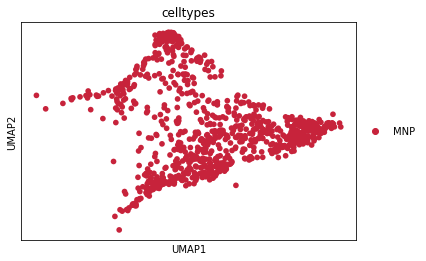

In [3]:
sc.pl.umap(adata, color = 'celltypes')

In [4]:
# read in the integrated mnp data
adata_ref = sc.read_h5ad('out/mnp.integrated_230621.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 793 × 3000
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

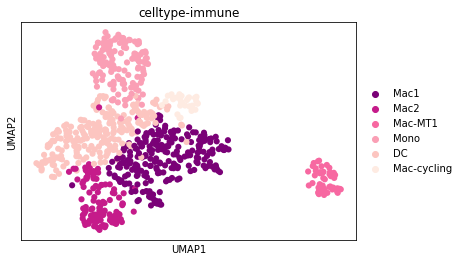

In [5]:
sc.pl.umap(adata_ref, color = 'celltype-immune')

In [6]:
# quick process
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 928 × 3000
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [8]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [9]:
sc.tl.ingest(adata, adata_ref, obs='celltype-immune')

running ingest
    finished (0:00:25)


In [10]:
adata

AnnData object with n_obs × n_vars = 928 × 3000
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes', 'celltype-immune'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'

In [11]:
adata.uns['celltype-immune_colors'] = adata_ref.uns['celltype-immune_colors']  # fix category colors

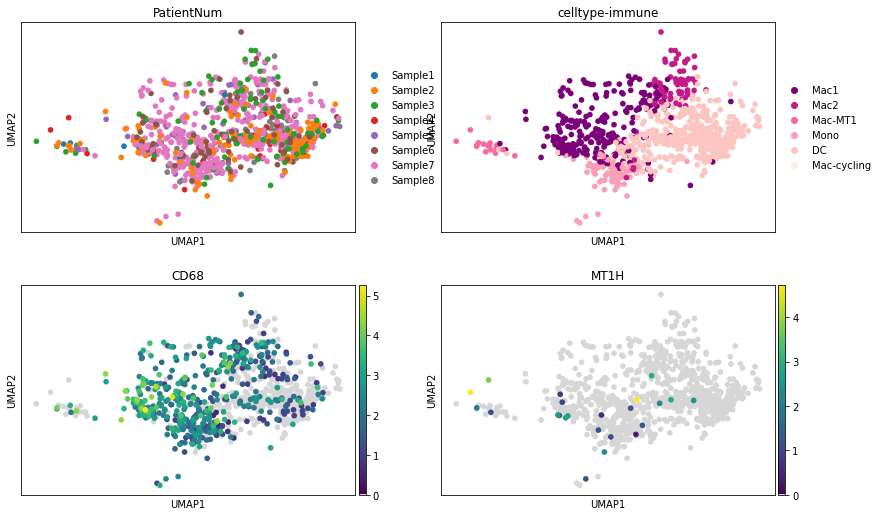

In [12]:
sc.pl.umap(adata, color = ['PatientNum', 'celltype-immune', 'CD68', 'MT1H'], color_map = cmp(), ncols = 2)

In [13]:
# save
adata.write_h5ad('dataset/Karthaus/karthaus_processed_mnp_ingested.h5ad', compression = 'gzip')